In [2]:
# NB need to use environment with python3.9 or above for ccf_streamlines to run
import nrrd
import numpy as np
import matplotlib.pyplot as plt
import ccf_streamlines.projection as ccfproj
import pathlib
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import copy

In [147]:
lcm_directory = pathlib.Path(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/LCM"
)
# load datasets
barcodes_across_sample = pd.read_pickle(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/Sequencing/barcode_matrix_soma_thresholded.pkl"
)
ROI_3D = np.load(lcm_directory / "ROI_3D.npy")

In [38]:
# this is the path to where the ccf streamlines downloads is (so don't change when looking a different mice)
convert_to_flat_path = pathlib.Path(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration"
)

In [148]:
# ignore barcodes that are only found in one sample
barcodes_across_sample = barcodes_across_sample[
    barcodes_across_sample.astype(bool).sum(axis=1) > 1
]

In [149]:
cortical_samples = [
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    66,
    70,
    71,
    72,
    73,
    74,
    75,
    76,
    77,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    87,
    88,
    93,
    94,
    95,
    96,
    97,
    98,
    99,
    100,
    101,
    102,
    103,
    104,
    105,
    106,
    107,
    108,
    109,
    110,
    111,
    112,
    113,
    117,
    118,
    119,
    120,
    121,
    122,
    123,
    124,
    125,
    126,
    127,
    128,
    132,
    133,
    134,
    135,
    136,
    137,
    138,
    139,
    140,
    141,
    142,
    143,
    147,
    148,
    149,
    150,
    151,
    153,
    154,
    155,
    156,
    157,
    158,
    159,
    161,
    162,
    163,
    164,
    165,
    167,
    168,
    169,
    170,
    172,
    173,
    174,
    175,
    177,
    178,
    179,
    180,
    181,
    182,
    183,
    184,
    185,
    186,
]

In [135]:
cortical_samples = [
    3,
    4,
    5,
    8,
    9,
    10,
    11,
    12,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    54,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    72,
    73,
    74,
    76,
    77,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    87,
    88,
    89,
    90,
    91,
    92,
    93,
    94,
    95,
    96,
    97,
    98,
    99,
    100,
    101,
    102,
    103,
    104,
    105,
    109,
    110,
    111,
    112,
    113,
    114,
    115,
    116,
    117,
    118,
    119,
    120,
    126,
    127,
    128,
    129,
    131,
    132,
    133,
    134,
    135,
    136,
    139,
    144,
    145,
    146,
    147,
    148,
    151,
    152,
    153,
    154,
    155,
    156,
    157,
    159,
    160,
    161,
    162,
    163,
    164,
    166,
    167,
    168,
    169,
    171,
    172,
    173,
    174,
    175,
    176,
]

In [150]:
# remove any samples from 3D array that aren't cortical for flatmap visualisation
mask = np.isin(ROI_3D, cortical_samples)
ROI_3D[~mask] = 0

In [151]:
def remove_hemisphere_overlap(roi_array):
    # determine the midpoint of the array along the z-axis (corresponds to the axis connecting hemipshperes)
    x_midpoint = roi_array.shape[2] // 2

    # select ROIs in each hemisphere
    left_hemisphere_roi = roi_array[:, :, :x_midpoint]
    right_hemisphere_roi = roi_array[:, :, x_midpoint:]

    # identify ROIs that are predominantly in one hemisphere
    left_hemisphere_labels = np.unique(left_hemisphere_roi)
    right_hemisphere_labels = np.unique(right_hemisphere_roi)

    majority_left_labels = [
        label
        for label in left_hemisphere_labels
        if np.sum(left_hemisphere_roi == label) > np.sum(right_hemisphere_roi == label)
    ]
    majority_right_labels = [
        label
        for label in right_hemisphere_labels
        if np.sum(right_hemisphere_roi == label) > np.sum(left_hemisphere_roi == label)
    ]

    # remove those crossing hemispheres where the majority of the ROI is in another hemisphere
    left_mask = np.isin(left_hemisphere_roi, majority_left_labels)
    left_hemisphere_roi[~left_mask] = 0
    right_mask = np.isin(right_hemisphere_roi, majority_right_labels)
    right_hemisphere_roi[~right_mask] = 0

    # Combine the hemispheres back into a single array
    roi_array_processed = np.concatenate(
        (left_hemisphere_roi, right_hemisphere_roi), axis=2
    )

    return roi_array_processed


# Example usage:
# Assuming roi_array is your 3D numpy array containing the ROIs
ROI_3D = remove_hemisphere_overlap(ROI_3D)

In [152]:
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path / "flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path / "labelDescription_ITKSNAPColor.txt",
)

# We get the left hemisphere region boundaries with the default arguments
bf_left_boundaries = bf_boundary_finder.region_boundaries()

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere="right_for_both",
    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere="flatmap_butterfly",
)

In [14]:
proj_top = ccfproj.Isocortex2dProjector(
    # Specify our view lookup file
    convert_to_flat_path / "flatmap_butterfly.h5",
    # Specify our streamline file
    convert_to_flat_path / "surface_paths_10_v3.h5",
    # Specify that we want to project both hemispheres
    hemisphere="both",
    # The top view contains space for the right hemisphere, but is empty.
    # Therefore, we tell the projector to put both hemispheres side-by-side
    view_space_for_other_hemisphere="flatmap_butterfly",
)

loading path information


100%|██████████| 1016/1016 [00:06<00:00, 168.74it/s]


In [153]:
# remove tubes in ROI flatmap that aren't in normalised barcode path
tubes = np.arange(
    np.min(barcodes_across_sample.columns), np.max(barcodes_across_sample.columns), 1
)
tubes_not_in = [i for i in tubes if i not in barcodes_across_sample.columns.to_list()]
for x in tubes_not_in:
    ROI_3D[ROI_3D == x] = 0

In [154]:
ROI_projection_max = proj_top.project_volume(ROI_3D)

In [155]:
barcode_matrix = np.zeros(
    (
        len(barcodes_across_sample),
        max(barcodes_across_sample.columns.to_list()) + 1,
    )
)
for column in barcodes_across_sample:
    barcode_matrix[:, column] = barcodes_across_sample[column].to_numpy()

In [156]:
total_counts = np.sum(barcode_matrix, axis=0)
# now set zero values to -1
total_counts[0] = -1

/tmp/ipykernel_143204/845795481.py:1: RuntimeWarning: divide by zero encountered in log10
  new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T


Text(0.5, 1.0, 'Distribution of total MAPseq counts FIAA45.6d')

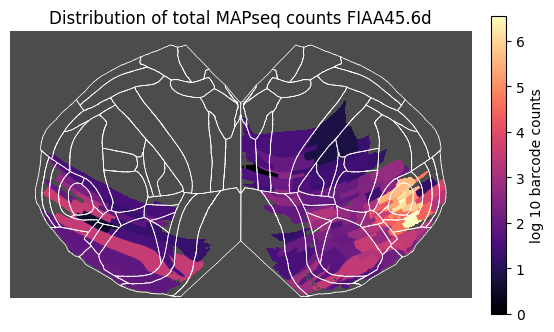

In [157]:
new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T

cmap = plt.cm.get_cmap("magma").copy()

cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

plt.imshow(new_mat, cmap=cmap)
plt.axis("off")
plt.colorbar(label="log 10 barcode counts", fraction=0.03, pad=0.04)
for k, boundary_coords in bf_left_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)
plt.title(f"Distribution of total MAPseq counts FIAA45.6d")

In [158]:
# now look at where soma locations are
# take sum of 'neurons' with max barcode count in each sample to see distribution of where the soma is
source_thresholded_soma_only_actual_val = pd.DataFrame(
    columns=barcodes_across_sample.columns
)
for i, r in barcodes_across_sample.iterrows():
    soma_sample = r.idxmax()
    row_data = [0] * len(barcodes_across_sample.columns)
    barcode_row = pd.DataFrame([row_data], columns=barcodes_across_sample.columns)
    barcode_row[r.idxmax()] = 1
    source_thresholded_soma_only_actual_val = pd.concat(
        [source_thresholded_soma_only_actual_val, barcode_row]
    )

In [159]:
soma_matrix = np.zeros(
    (
        len(barcodes_across_sample),
        max(barcodes_across_sample.columns.to_list()) + 1,
    )
)
for column in source_thresholded_soma_only_actual_val:
    soma_matrix[:, column] = source_thresholded_soma_only_actual_val[column].to_numpy()
soma_counts = np.sum(soma_matrix, axis=0)


# now set zero values to -1
soma_counts[0] = -1

/tmp/ipykernel_143204/1131966589.py:2: RuntimeWarning: divide by zero encountered in log10
  new_mat = np.log10(1 + soma_counts[ROI_projection_max.astype(int)]).T


Text(0.5, 1.0, 'Location of barcode cell bodies FIAA45.6d')

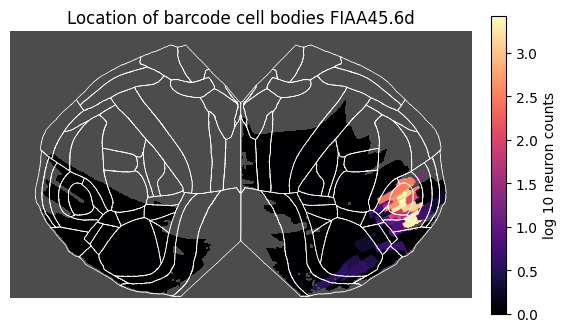

In [160]:
# new_mat = log_soma[ROI_projection_max.astype(int)].T
new_mat = np.log10(1 + soma_counts[ROI_projection_max.astype(int)]).T
cmap = plt.cm.get_cmap("magma").copy()

cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

plt.imshow(new_mat, cmap=cmap)
plt.axis("off")
plt.colorbar(label="log 10 neuron counts", fraction=0.03, pad=0.04)
for k, boundary_coords in bf_left_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)
plt.title(f"Location of barcode cell bodies FIAA45.6d")

In [94]:
source_thresholded_soma_only_actual_val

,1,2,3,4,5,6,7,8,9,11,...,171,172,173,174,175,176,177,178,179,180
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
barcodes_across_sample

,1,2,3,4,5,6,7,8,9,11,...,171,172,173,174,175,176,177,178,179,180
sequence,,,,,,,,,,,,,,,,,,,,,
ATCCCTGCGGGGATCGGAGTGTATGGGGGTTC,0.0,0.000000,5.120291,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0
GACTTCTTTTAGAACATACTTTTCAATCAATC,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0
TACTCGCCTCGAGTATCAAGATAATAATGCCT,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.490955,0.0,0.0,1.48249,0.0
TCGAGGAGAGCCGGACCCGCTCCCGGGAGCTC,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0
TGCGATCTGCCCACGTCGGCCGGTCATGTCTT,0.0,6.720451,0.000000,0.0,0.0,3.715142,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.490955,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCGTTACCCGCCGTAATTCGAAGGTATGTTT,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0
GCTCCTCGGACGAGGCCGCGGTCGGGGGATTT,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0
ATGATGGTTAGTACACGGGTCTGTATGTATTT,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0


In [92]:
soma_counts.max()

2143993.5354101295